# Project - Determining Remaining Useful Life (RUL) of Aircraft Turbofan Engines 
Author: Brandon Attai
Course: ENSF 612 Final Project

In [2]:
#Import the required Libraries

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from numpy import genfromtxt

## Load Data

### Description of Data

Source: CMAPSS Dataset

Data Set: FD001
Train trjectories: 100
Test trajectories: 100
Conditions: ONE (Sea Level)
Fault Modes: ONE (HPC Degradation)

Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1)	unit number
2)	time, in cycles
3)	operational setting 1
4)	operational setting 2
5)	operational setting 3
6)	sensor measurement  1
7)	sensor measurement  2
...
26)	sensor measurement  26

## Dataset Features

- Superviesed Learning Task
- Multiple Regression
- Univariate Regression
- Plain Batch Learning

### Definitions
- engine: the index of the turbofan engine
- cycles: the cycle, i.e. 1 takeoff and landing

In [3]:
#Column names from README.md
col_name = ['engine', 'cycles', 'op1', 'op2', 'op3',
            'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
            'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10',
            'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
            'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
            'sensor21', 'sensor22', 'sensor23']

In [4]:
#Import Data
train_original = pd.read_csv("CMAPSSData/train_FD001.txt", sep=" ", header=None, names = col_name)
test_original = pd.read_csv("CMAPSSData/test_FD001.txt", sep= " ", header=None, names = col_name)
y_test_original = genfromtxt("CMAPSSData/RUL_FD001.txt", delimiter=',')


In [5]:
train_original.head()

,engine,cycles,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [6]:
test_original.head()

,engine,cycles,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [7]:
#Details on the engine and operational settings
engine_details = ['engine', 'cycles', 'op1', 'op2', 'op3',]
train_original[engine_details].groupby('engine').max().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cycles,100.0,206.310000,46.342749,128.0000,177.000000,199.0000,229.250000,362.0000
op1,100.0,0.005986,0.000883,0.0040,0.005375,0.0059,0.006425,0.0087
op2,100.0,0.000497,0.000056,0.0004,0.000500,0.0005,0.000500,0.0006
op3,100.0,100.000000,0.000000,100.0000,100.000000,100.0000,100.000000,100.0000


In [8]:
#Details on the sensors
sensor_names = ['engine','sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
            'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10',
            'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
            'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
            'sensor21']

train_original[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
sensor1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
sensor6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
sensor7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
sensor8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
sensor9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900


In [9]:
#Using a copy of the training set to not harm the original train set
train = train_original.copy()

In [10]:
#Drop null columns in training set
train.drop(columns=['sensor22', 'sensor23'], inplace=True)

### Initial Thoughts

The cycles have a mean, std, min, 25%, 50%, 75% and	max of 206.31, 46.34, 128.00, 177.00, 199.00, 229.25 and 362.00 respectively. This indicates that the average failure of an engine occurs at 206 cylces, with the earliest failure at 128 cycles and the latest failure at 362 cycles.

The sensors 1, 5, 10, 16, 18 and 19 have negligble standard deviations.

## Data Visualization

In [11]:
#Get the maximum cycles for each engine in the dataset
max_cycles = train.groupby('engine').max()['cycles'].to_frame()

In [12]:
#Reset the index and add number for engine number
engine_list = []
for x in range(1, 101):
    engine_list.append(x)

max_cycles.insert(0, column = 'engine', value = engine_list)
max_cycles.index.name = ''

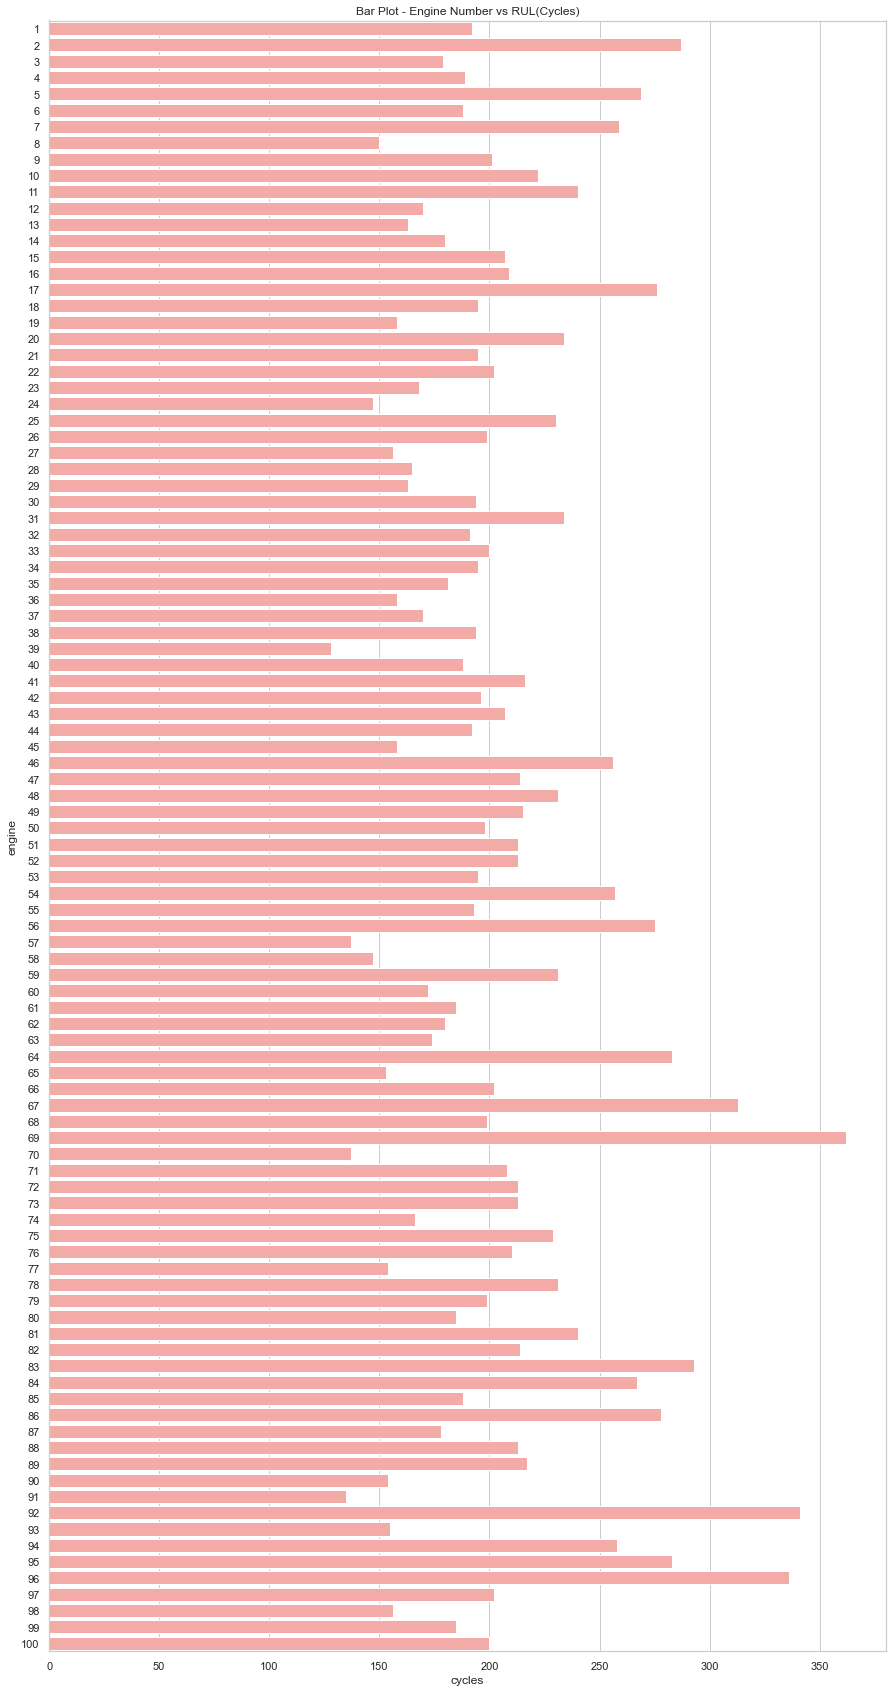

In [13]:
#Plot the maximum cycles for each engine
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 30))

sns.set_color_codes("pastel")
sns.barplot(x='cycles', y='engine', data=max_cycles,
             color="r", orient = 'h').set(title= "Bar Plot - Engine Number vs RUL(Cycles)")
plt.show()


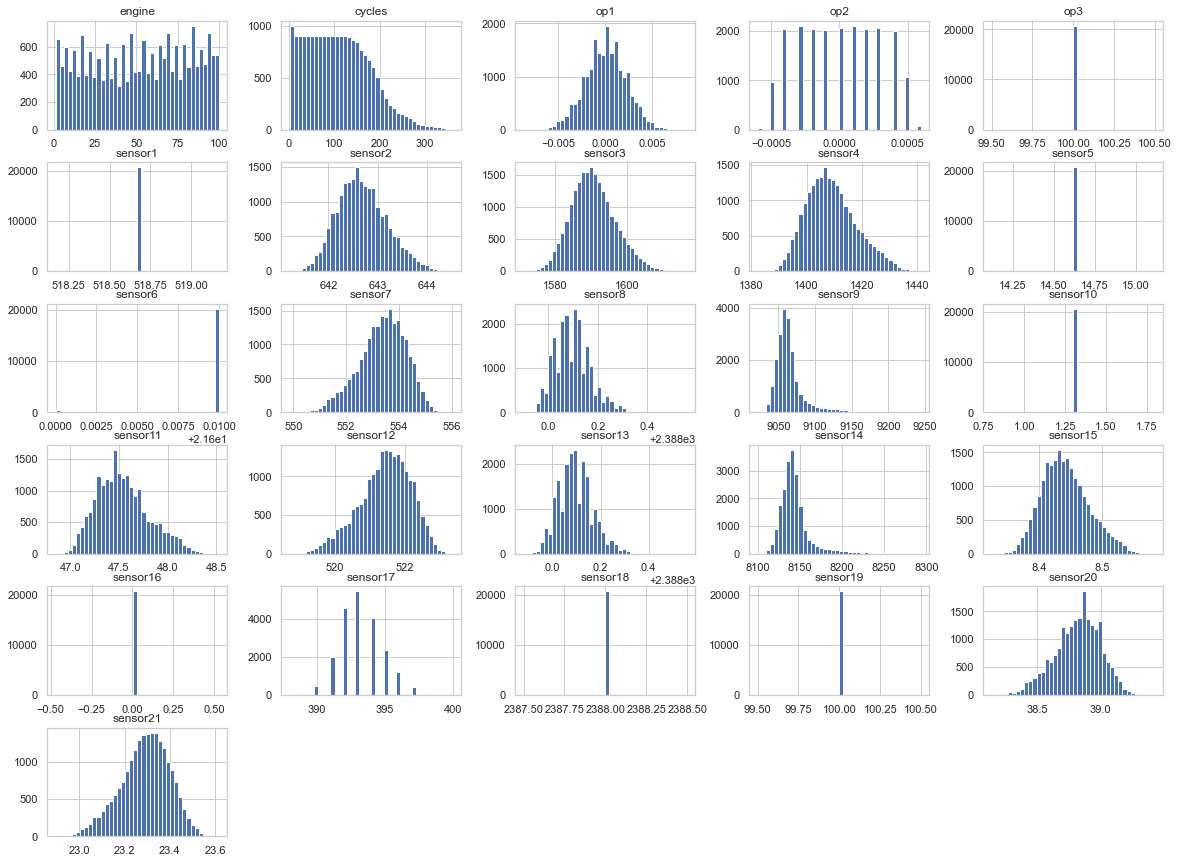

In [14]:
#Plot a histograms of the features
train.hist(bins=40, figsize=(20,15))
plt.show()

In [15]:
#Insert the remaining cycles for each engine
max_cycles_list = max_cycles['cycles'].to_list()
rul = []
for i in max_cycles_list:
    for x in range(i):
        rul.append(i-x-1)

#RUL (Remaining Useful Life) DataFrame - Derived Target
train_rul = train.filter(['engine', 'cycles'], axis=1)
train_rul['rul'] = rul
train_rul.head()

,engine,cycles,rul
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [16]:
#Compute the RUL for each engine.
max_rul = train_rul.groupby('engine').max().reset_index()
max_rul

,engine,cycles,rul
0,1,192,191
1,2,287,286
2,3,179,178
3,4,189,188
4,5,269,268
...,...,...,...
95,96,336,335
96,97,202,201
97,98,156,155
98,99,185,184


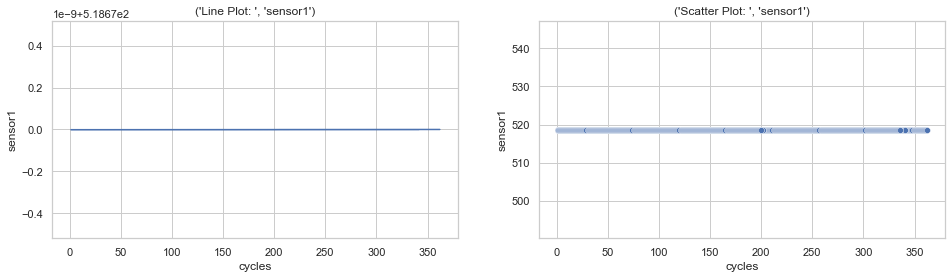

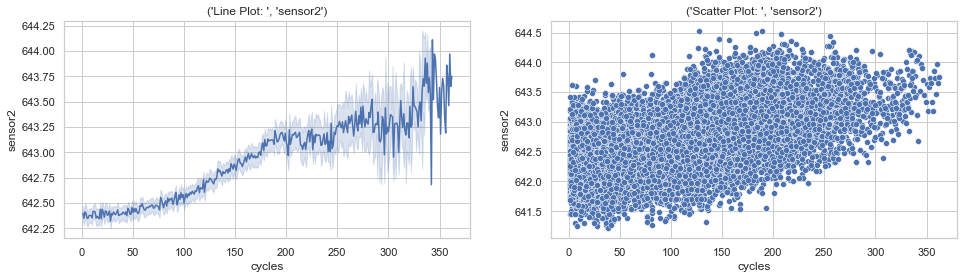

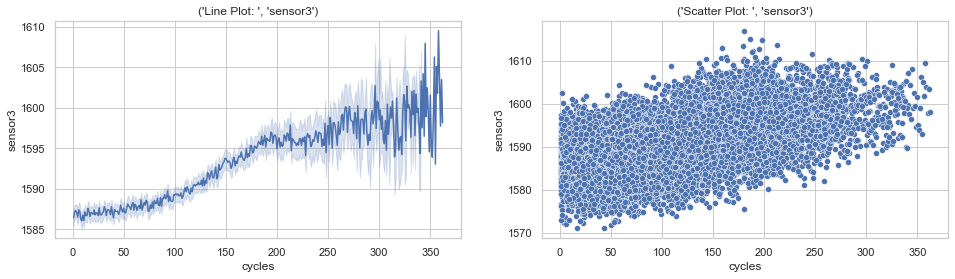

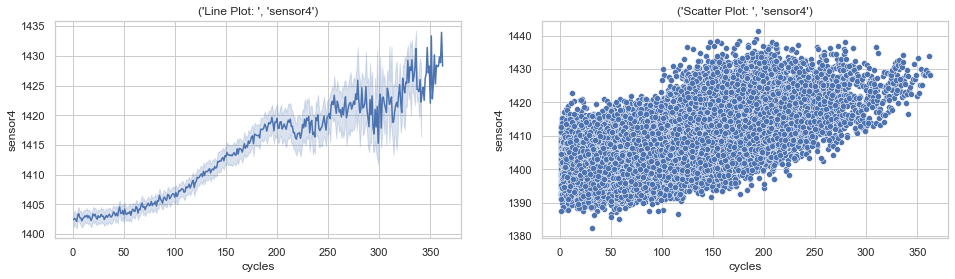

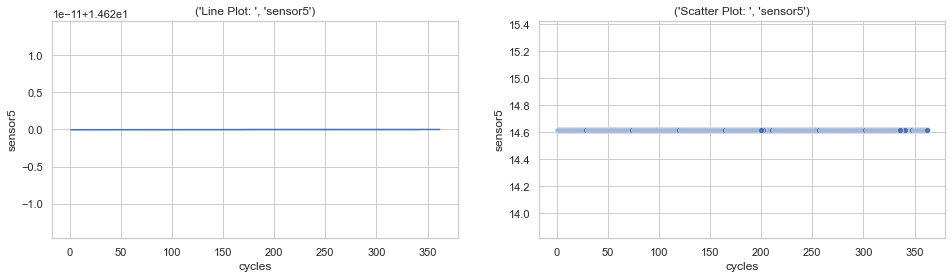

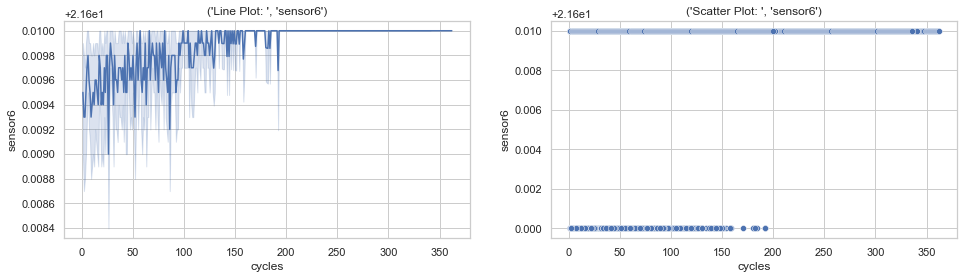

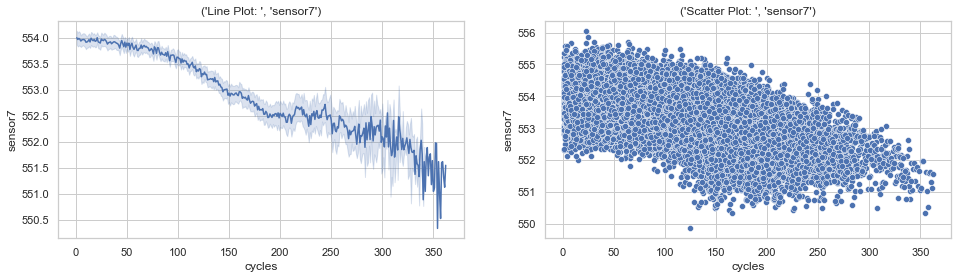

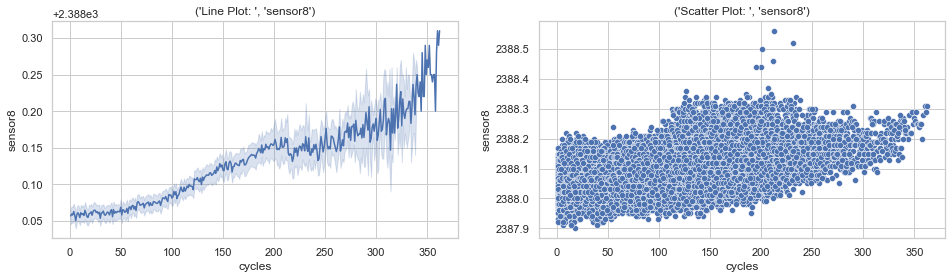

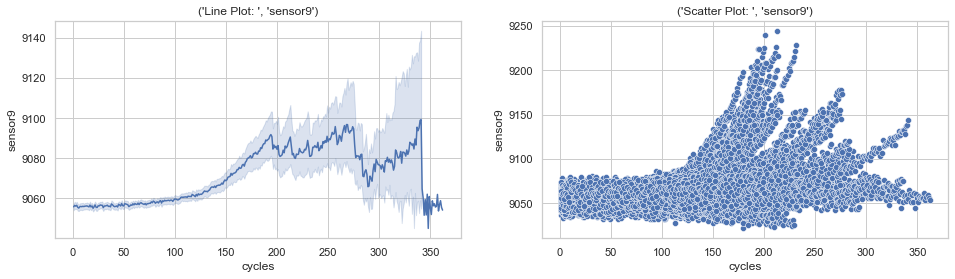

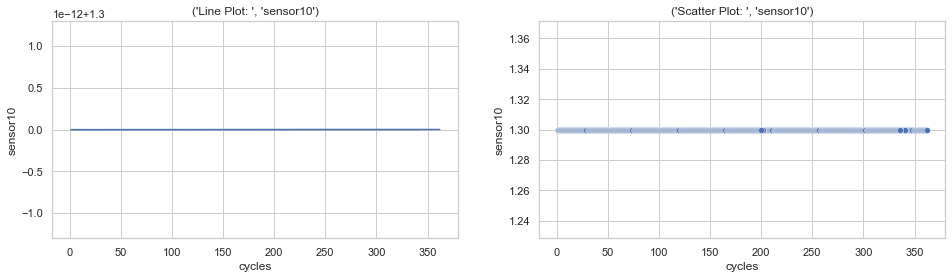

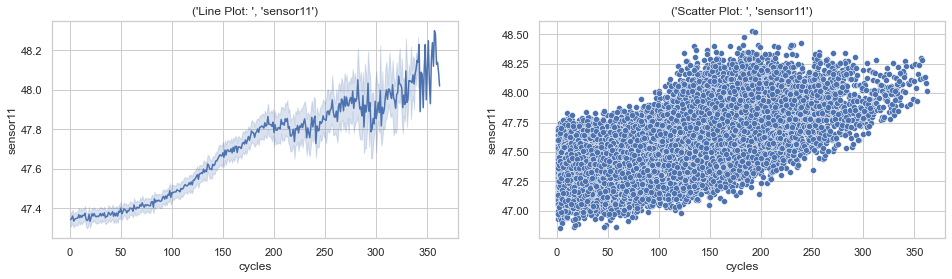

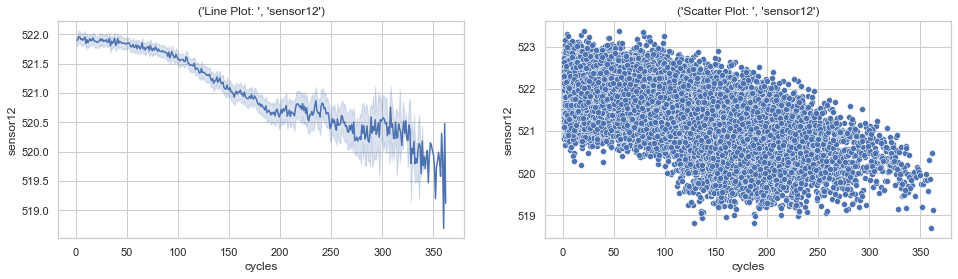

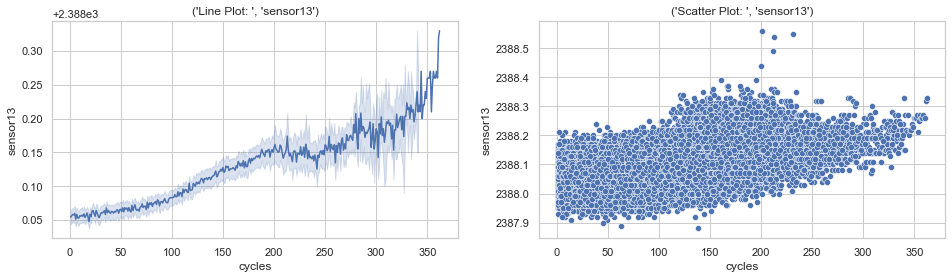

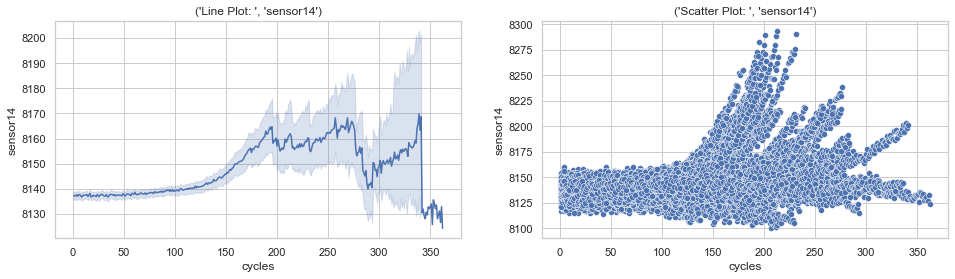

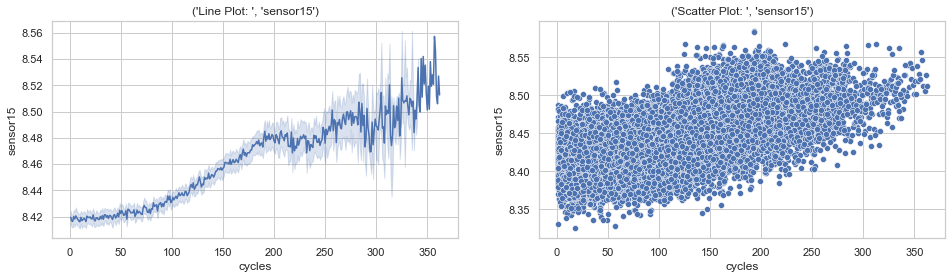

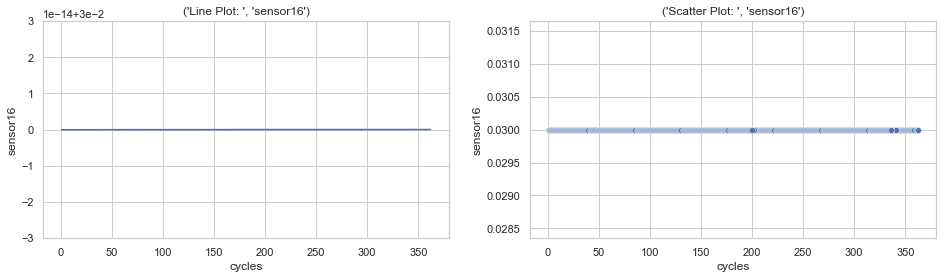

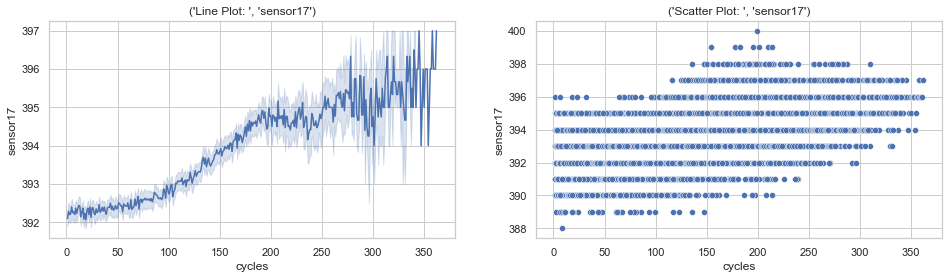

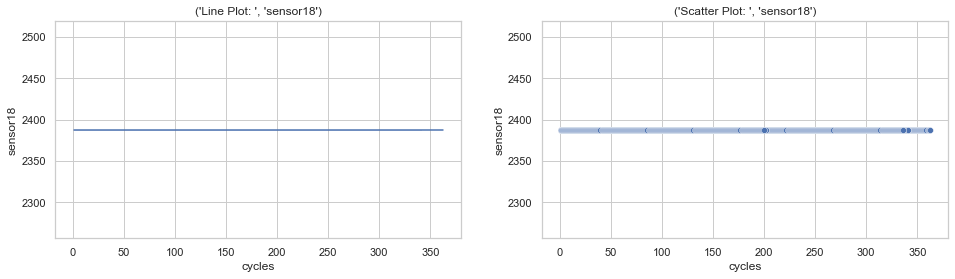

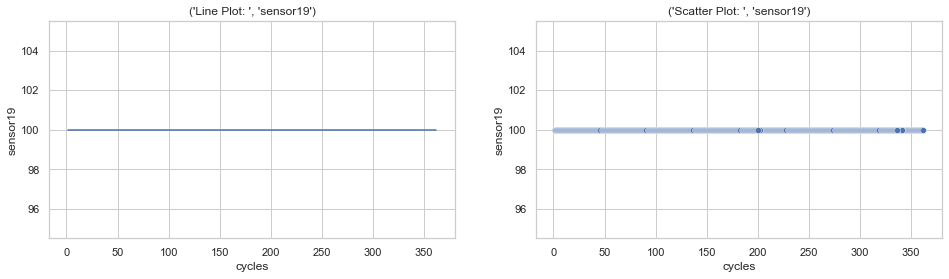

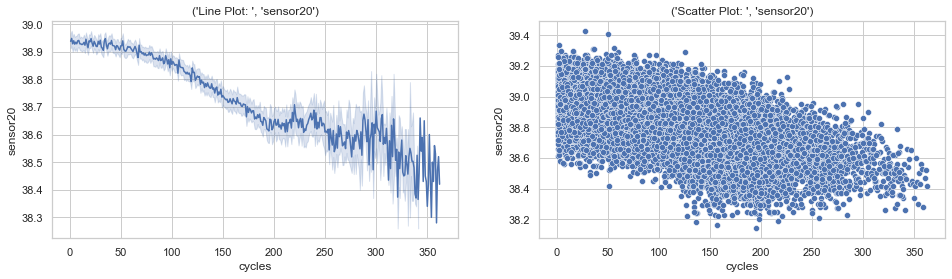

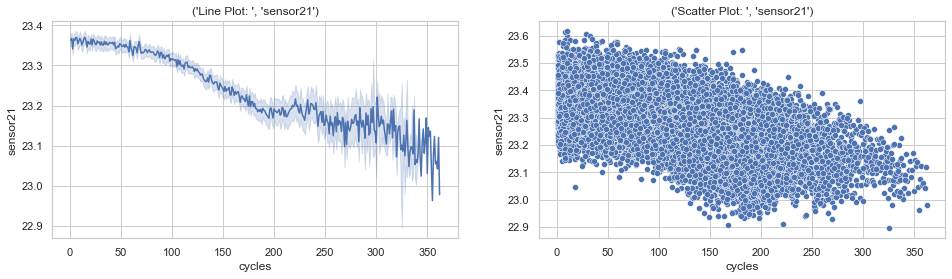

In [33]:
#Line plot for each sensor
sensors = ['sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
            'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10',
            'sensor11', 'sensor12', 'sensor13', 'sensor14', 'sensor15',
            'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
            'sensor21']




for sensor in sensors:
    fig, ax =plt.subplots(1,2, figsize=(16, 4))
    sns.lineplot(data=train, x='cycles', y=sensor, ax=ax[0]).set(title= ("Line Plot: ", sensor))
    sns.scatterplot(data=train, x='cycles', y=sensor, ax=ax[1]).set(title= ("Scatter Plot: ", sensor))
    plt.show()

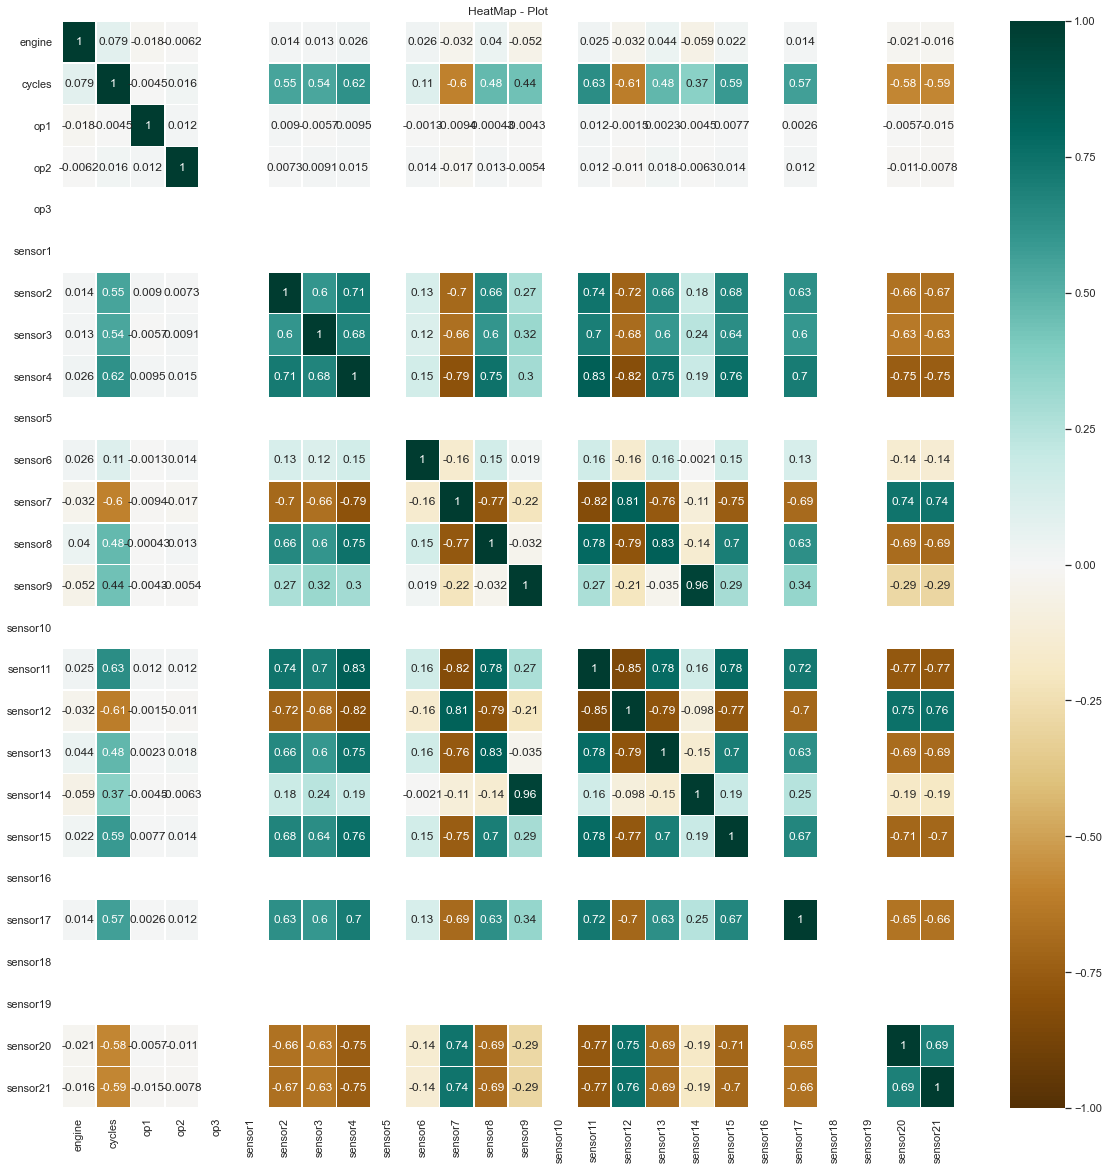

In [34]:
#Cross-correlation heatmap of features

plt.figure(figsize=(20,20))
ax = sns.heatmap(train.corr(), vmin=-1,vmax=1, annot=True, cmap='BrBG', linewidths=.5).set(
                                    title = 'HeatMap - Plot')
plt.show()

## Feature Engineering

In [40]:
#Check for null values in the dataset
count_null = train.isna().sum().sum()
print("Number of null values: " + str(count_null) + ".")

Number of null values: 0.


In [42]:
#Dropping the columns with negligible impact on the training set

train.drop(columns=['sensor1',
                    'sensor5',
                    'sensor10',
                    'sensor16',
                    'sensor18',
                    'sensor19'], inplace=True)

In [43]:
train_to_scale = train.copy()

#Dropping columns with negligble impact
train_to_scale.drop(columns=['engine','cycles','op1','op2','op3'], inplace=True)
train_to_scale_attribs = list(train_to_scale)
train_to_scale_attribs

['sensor2',
 'sensor3',
 'sensor4',
 'sensor6',
 'sensor7',
 'sensor8',
 'sensor9',
 'sensor11',
 'sensor12',
 'sensor13',
 'sensor14',
 'sensor15',
 'sensor17',
 'sensor20',
 'sensor21']

In [48]:
#Feature Scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('std_scaler', StandardScaler())])
train_tr = pipeline.fit_transform(train_to_scale)

In [49]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([("ct", pipeline, train_to_scale_attribs)])
train_cleaned = full_pipeline.fit_transform(train_to_scale)

In [50]:
train_cleaned

array([[-1.72172539, -0.13425518, -0.92593596, ..., -0.78170979,
         1.34849274,  1.19442705],
       [-1.06177971,  0.21152849, -0.64372587, ..., -0.78170979,
         1.01652793,  1.23692196],
       [-0.66181262, -0.41316559, -0.52595315, ..., -2.07309423,
         0.73989059,  0.50342281],
       ...,
       [ 1.47801126,  1.94697106,  2.13837684, ...,  3.09244354,
        -2.08181033, -3.29248147],
       [ 1.09804254,  2.40366648,  1.95505138, ...,  1.15536688,
        -2.91172236, -2.08507166],
       [ 2.33794049,  1.60771161,  2.57835793, ...,  1.8010591 ,
        -2.46910261, -2.19408035]])

## Models

In [56]:
#Test Data set
X_test = test_original.copy()
y_test = y_test_original.copy()

In [57]:
#Prepare Test dataset
X_test = X_test.groupby('engine').last().reset_index()
X_test.drop(columns=['sensor1',
                    'sensor5',
                    'sensor10',
                    'sensor16',
                    'sensor18',
                    'sensor19',
                     'sensor22',
                     'sensor23',
                     'engine',
                     'cycles',
                     'op1',
                     'op2',
                     'op3'], inplace=True)

X_test_prepared = full_pipeline.transform(X_test)

In [58]:
len(X_test_prepared)

100

In [59]:
#Train Data set
X_train = train_cleaned.copy()
y_train = train_rul['rul'].copy()

In [60]:
from sklearn.model_selection import cross_validate


def get_regressor_neg_rms(model, X, y, cv=7):
    #Source ENSF 611 Lab 2
    '''Calculate train and validation score for regressor (model) using cross-validation
        
        score is negative root mean-squared error (rms).
        
        model (sklearn classifier): Regressor to train and evaluate
        X (numpy.array or pandas.DataFrame): Feature matrix
        y (numpy.array or pandas.Series): Target vector
        
        returns: mean training negative rms, mean validation negative rms
    
    '''
    
    
    #TODO: add function body here
    regressor = model.fit(X,y)
    scores = cross_validate(regressor, X_train, y_train, cv=7, scoring=('neg_root_mean_squared_error'),  return_train_score=True)
    mean_training_neg_rms = scores['train_score'].mean()
    mean_validation_neg_rms = scores['test_score'].mean()
    
    return mean_training_neg_rms, mean_validation_neg_rms

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

rgr_lr = LinearRegression()
rgr_rf = RandomForestRegressor()
rgr_gbr = GradientBoostingRegressor()
svr_rgr = SVR(C=1.0, epsilon=0.2)

models = [svr_rgr, rgr_lr, rgr_rf, rgr_gbr]

print("Root Mean Squared Error\n")
for model in models:
    train, validation = (get_regressor_neg_rms(model, X_train, y_train, 7))
    print(model," - Training Score:",format(-train,".2f"))
    print(model," - Validation Score:", format(-validation,".2f"))


Root Mean Squared Error

SVR(epsilon=0.2)  - Training Score: 42.21
SVR(epsilon=0.2)  - Validation Score: 42.09
LinearRegression()  - Training Score: 44.61
LinearRegression()  - Validation Score: 44.39
RandomForestRegressor()  - Training Score: 15.54
RandomForestRegressor()  - Validation Score: 42.38
GradientBoostingRegressor()  - Training Score: 40.07
GradientBoostingRegressor()  - Validation Score: 41.89


## Finding the best model

In [65]:
#Setting up the parameter grid for grid search on the Random Forest Regressor.

from sklearn.model_selection import GridSearchCV

param_grid = [
{'bootstrap': [False, True],'n_estimators': [100, 500, 1000],'max_features': ['auto','sqrt' ,'log2', None]}]

In [66]:
#5 CV Grid search, scoring neg mean squared error for the Random Forest Regressor.

grid_search = GridSearchCV(rgr_rf, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)

In [67]:
#Perform grid search
#Note time to grid search approx 3 hours.

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'bootstrap': [False, True],
                          'max_features': ['auto', 'sqrt', 'log2', None],
                          'n_estimators': [100, 500, 1000]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
#Grid Search Best Parameters
grid_search.best_params_

{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 1000}

In [69]:
#Grid Search Best Estimator
grid_search.best_estimator_

RandomForestRegressor(max_features='log2', n_estimators=1000)

In [70]:
#Final model to be used
final_model = grid_search.best_estimator_

In [71]:
#Final Predictions
final_predictions = final_model.predict(X_test_prepared)

## Results

In [72]:
#Final Model Results
print("\nFor retrained best estimator on test set: ")
print("Mean Squared Error: ", format(mean_squared_error(y_test, final_predictions, squared=False), ".2f"))
print("r2_score: ", format(r2_score(y_test, final_predictions), ".3f"))


For retrained best estimator on test set: 
Mean Squared Error:  32.64
r2_score:  0.383


In [73]:
final_predictions = final_predictions.astype(int)
final_predictions

array([165, 149,  65,  98, 119, 128, 121, 105, 128, 127,  72,  87,  99,
       129, 183, 134,  53,  69, 141,  24,  71, 146, 169,  28, 153, 124,
       144, 104, 114, 109,  19,  54, 113,   6,   8,  25,  53,  51, 154,
        30,  71,  18,  70, 131,  81,  54, 144, 134,  14, 134, 139,  30,
        34, 165, 146,  13, 123,  53, 174, 140,  43,  55,  64,  47, 173,
        16, 167,  17, 148, 129, 141,  71, 172, 109, 168,  14,  34, 193,
       140,  85,   7,   9, 147,  55, 142,  84, 141, 152, 131,  40,  32,
        22,  48,  50, 159, 166,  78,  93, 155,  17])

In [75]:
actual_values = y_test_original.astype(int)
actual_values

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20])

## Appendix

In [88]:
#Quick Test of PCA

from sklearn.decomposition import PCA


pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train)

rgr_rf_pca_train = RandomForestRegressor(max_features='log2', n_estimators=1000)
rgr_rf_pca_train.fit(X_train_pca, y_train)


final_predictions_pca = rgr_rf_pca_train.predict(X_test_pca)

In [89]:

print("\nFor retrained best estimator on test set: ")
print("Mean Squared Error: ", format(mean_squared_error(y_test, final_predictions_pca, squared=False), ".2f"))
print("r2_score: ", format(r2_score(y_test, final_predictions_pca), ".3f"))


For retrained best estimator on test set: 
Mean Squared Error:  38.02
r2_score:  0.163
